# Imports

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import xgboost as xgb
from tqdm import tqdm

# Data loading

In [ ]:
! gdown 1I4UJIytuZtFO_0o-YKz7kqwAro97KLM_

Downloading...
From: https://drive.google.com/uc?id=1I4UJIytuZtFO_0o-YKz7kqwAro97KLM_
To: /content/estate_data.zip
100% 1.74M/1.74M [00:00<00:00, 104MB/s]


In [ ]:
! unzip estate_data.zip

Archive:  estate_data.zip
  inflating: Home Sale Data.csv      


# Data preprocessing

In [ ]:
data = pd.read_csv('Home Sale Data.csv', sep=';')

In [ ]:
data.head()

,District,Neighborhood,Price,Adrtisement Date,m² (Gross),m² (Net),Number of rooms,Building Age,Floor location,Number of floors,...,Top floor,Garage / Shop Top,Entrance floor,Floor Duplex,Private Entry,Rerse Duplex,Triplex,Ground floor,Roof Duplex,Pick Up Data Time
0,Tuzla,Aydınlı Mh.,165.000 TL,04.01.2020,50,40.0,1+1,5-10 between,5,13,...,0,0,0,0,0,0,0,0,0,01.08.2020
1,Fatih,Katip Kasım Mh.,207.000 TL,06.01.2020,42,42.0,1+1,31 and more than,Ground floor,3,...,0,0,0,0,0,0,0,0,0,01.10.2020
2,Çekmeköy,Çatalmeşe Mh.,153.000 TL,31.12.2019,55,45.0,1+1,1,Kot 1,7,...,0,0,0,0,0,0,0,0,0,01.10.2020
3,Çekmeköy,Mehmet Akif Ersoy Mah.,205.000 TL,29.12.2019,62,46.0,1+1,0,High entrance,5,...,0,0,0,0,0,0,0,0,0,01.10.2020
4,Küçükçekmece,Halkalı Merkez Mh.,150.000 TL,01.01.2020,70,55.0,1+1,5-10 between,Garden Floor,4,...,0,0,0,0,0,0,0,0,0,01.07.2020


In [ ]:
print(data.dtypes.to_markdown())

|                                 | 0       |
|:--------------------------------|:--------|
| District                        | object  |
| Neighborhood                    | object  |
| Price                           | object  |
| Adrtisement Date                | object  |
| m² (Gross)                      | int64   |
| m² (Net)                        | float64 |
| Number of rooms                 | object  |
| Building Age                    | object  |
| Floor location                  | object  |
| Number of floors                | object  |
| Heating                         | object  |
| Number of bathrooms             | object  |
| Balcony                         | object  |
| Furnished                       | object  |
| Using status                    | object  |
| Available for Loan              | object  |
| From who                        | object  |
| Swap                            | object  |
| Front West                      | int64   |
| Front East                      

Drop missing values

In [ ]:
data = data.dropna()

Drop duplicates

In [ ]:
data = data.drop_duplicates()

## Numerical columns processing


Number of rooms transform

In [ ]:
data['Studio'] = data['Number of rooms'].str.contains('Studio').astype(int)
data.loc[data['Number of rooms'] == '10 and more than', 'Number of rooms'] = data.loc[data['Number of rooms'] == '10 and more than', 'Number of rooms'].copy().str[:2]
data['Number of rooms'] = data['Number of rooms'].apply(lambda x: sum(map(float, [_ for _ in x.split('+') if _.isdigit()])))

<ipython-input-7-9afe4ab0bb9d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Studio'] = data['Number of rooms'].str.contains('Studio').astype(int)


Floor location transform

In [ ]:
for floor in data['Floor location'].unique():
    if not floor.isdigit():
        data[floor] = np.int64(data['Floor location'] == floor)
        data.loc[data['Floor location'] == floor, 'Floor location'] = 0

In [ ]:
data['Floor location'] = data['Floor location'].astype(int)

Number of floors transform

In [ ]:
data.loc[data['Number of floors'] == '30  and more than', 'Number of floors'] = data.loc[data['Number of floors'] == '30  and more than', 'Number of floors'].copy().str[:2]

In [ ]:
data['Number of floors'] = data['Number of floors'].astype(int)

Number of bathrooms transform

In [ ]:
data.loc[data['Number of bathrooms'] == '6 and more than', 'Number of bathrooms'] = data.loc[data['Number of bathrooms'] == '6 and more than', 'Number of bathrooms'].copy().str[:2]
data.loc[data['Number of bathrooms'] == 'Absent', 'Number of bathrooms'] = 0

In [ ]:
data['Number of bathrooms'] = data['Number of bathrooms'].astype(int)

Drop timestamp columns

In [ ]:
data = data.drop(['Adrtisement Date', 'Pick Up Data Time'], axis=1)

Price transformation

In [ ]:
data['Price'] = data['Price'].str[:-3]
data['Price'] = data['Price'].str.replace('.', '')
data['Price'] = data['Price'].astype(int)

<ipython-input-15-0e3622b6a868>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['Price'] = data['Price'].str.replace('.', '')


<Axes: xlabel='Price', ylabel='Density'>

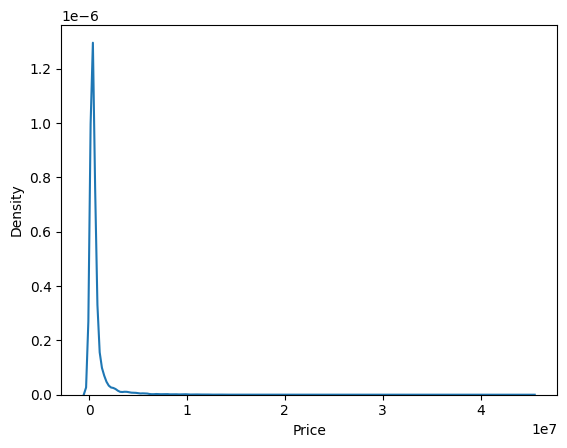

In [ ]:
sns.kdeplot(data['Price'])

In [ ]:
data['Price'] = data['Price'].apply(np.log)

<Axes: xlabel='Price', ylabel='Density'>

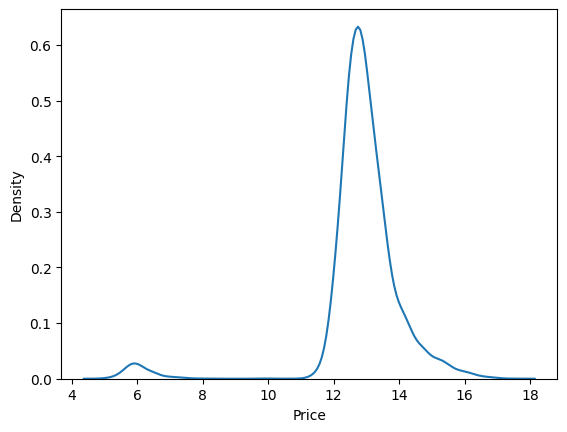

In [ ]:
sns.kdeplot(data['Price'])

## Data encoding

In [ ]:
categorical_columns = [column for column in data.columns if data[column].dtype == 'object']

In [ ]:
encoder = OneHotEncoder(sparse_output=False, drop='if_binary')

In [ ]:
encoded_data = encoder.fit_transform(data[categorical_columns])

In [ ]:
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out())

In [ ]:
data = data.drop(categorical_columns, axis=1)
data = pd.concat([data.reset_index(drop=True), encoded_df], axis=1)

## Multicolinearity check

In [ ]:
numerical_columns = ['m² (Gross)', 'm² (Net)', 'Number of rooms', 'Floor location', 'Number of floors', 'Number of bathrooms']

In [ ]:
data[numerical_columns].corr()

,m² (Gross),m² (Net),Number of rooms,Floor location,Number of floors,Number of bathrooms
m² (Gross),1.000000,0.696739,0.557546,0.119238,0.015232,0.509130
m² (Net),0.696739,1.000000,0.797759,0.123247,-0.046925,0.690948
Number of rooms,0.557546,0.797759,1.000000,0.086457,-0.121633,0.598428
Floor location,0.119238,0.123247,0.086457,1.000000,0.652733,0.185262
Number of floors,0.015232,-0.046925,-0.121633,0.652733,1.000000,0.080783
Number of bathrooms,0.509130,0.690948,0.598428,0.185262,0.080783,1.000000


<Axes: >

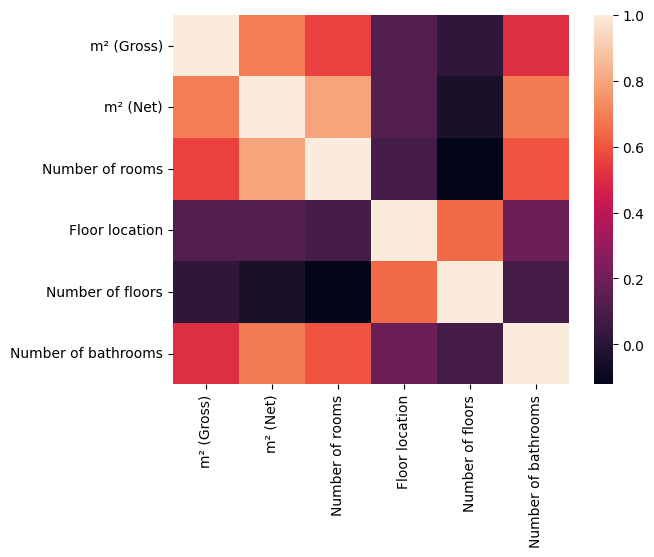

In [ ]:
sns.heatmap(data[numerical_columns].corr())

In [ ]:
data = data.drop('Number of rooms', axis=1)

## Train test split

In [ ]:
train_data, test_data = train_test_split(data, test_size=.3, random_state=17)

## Data scaling

In [ ]:
columns_to_scale = [
    'Price', 'm² (Gross)', 'm² (Net)', 'Floor location',
    'Number of floors', 'Number of bathrooms'
    ]

In [ ]:
scaler = StandardScaler()
train_data[columns_to_scale] = scaler.fit_transform(train_data[columns_to_scale])
test_data[columns_to_scale] = scaler.transform(test_data[columns_to_scale])

In [ ]:
train_features = train_data.drop('Price', axis=1)
train_labels = train_data['Price']
test_features = test_data.drop('Price', axis=1)
test_labels = test_data['Price']

## Backward feature elimination

In [ ]:
features_to_remove = []

for feature in tqdm(train_features.columns):
    feature_selection_model = sm.OLS(endog=train_labels, exog=train_features).fit()
    results_as_html = feature_selection_model.summary().tables[1].as_html()
    results_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
    max_p_value = results_df['P>|t|'].max()
    if max_p_value > .05:
        feature_to_remove = results_df['P>|t|'].idxmax()
        train_features = train_features.drop(, axis=1)
        features_to_remove.append(feature_to_remove)
    else:
        break

 44%|████▍     | 382/869 [1:12:24<1:32:19, 11.37s/it]


In [ ]:
test_features = test_features.drop(features_to_remove, axis=1)

## Cleaning outliers

In [ ]:
outlier_detection_model = IsolationForest()
outlier_detection_model.fit(train_features)

IsolationForest()

In [ ]:
anomaly_scores = outlier_detection_model.decision_function(train_features)

In [ ]:
threshold = -0.5
outlier_mask = anomaly_scores < threshold

train_features = train_features[~outlier_mask]

# Data modeling

## Model training

In [ ]:
model = xgb.XGBRegressor(
    learning_rate=.1, n_estimators=4, max_depth=400, random_state=17
)
model.fit(train_features, train_labels)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=400, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=4, n_jobs=None,
             num_parallel_tree=None, random_state=17, ...)

## Model evaluation

In [ ]:
mean_squared_error(train_labels, model.predict(train_features))

0.4520851758190634

In [ ]:
mean_squared_error(test_labels, model.predict(test_features))

0.4943948337346558